## TODOS:

- Implement reweighted FIL, test on dataset (DETAILS??)
- Figure out what is causing memory issues and SINGULAR MATRICES (??)
- Test on different datasets (DETAILS??)
- Test Differential Privacy on the toy datasets below
- Test Differential Privacy on different datasets (DETAILS??)
- Correlation between OOD and FIL

In [ ]:
import abc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from fil import FIL_Logistic, FIL_Linear
from utils import *

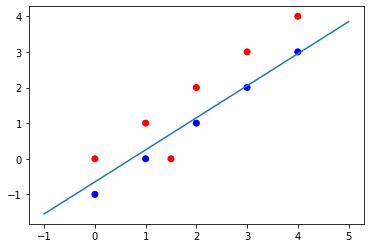

coefficients: 0.48488552901501014, -0.6719133024381662, 0.7472929514995215
Point: [1. 0. 0.], Value: 1, FIL: 0.334
Point: [1. 1. 1.], Value: 1, FIL: 0.166
Point: [1. 2. 2.], Value: 1, FIL: 0.214
Point: [1. 3. 3.], Value: 1, FIL: 0.43
Point: [1. 4. 4.], Value: 1, FIL: 0.659
Point: [ 1.  0. -1.], Value: 0, FIL: 1.013
Point: [1. 1. 0.], Value: 0, FIL: 0.884
Point: [1. 2. 1.], Value: 0, FIL: 0.808
Point: [1. 3. 2.], Value: 0, FIL: 0.798
Point: [1. 4. 3.], Value: 0, FIL: 0.857
Point: [1.  1.5 0. ], Value: 1, FIL: 1.333


In [ ]:
# define dataset
X = np.array([[x, x] for x in range(5)] + [[x, x-1] for x in range(5)])
X = np.vstack((X, np.array([[1.5, 0]]))) # Add one atypical data point 
y = np.array([1] * 5 + [0] * 5 + [1]) # labels

# define logistic regression model
clf = LogisticRegression().fit(X, y)

# calculate the intercept and slope of the decision boundary.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
c = -b/w2
m = -w1/w2

# plot the data and the classification with the decision boundary.
xmin, xmax = -1, 5
ymin, ymax = -1, 5
xd = np.array([xmin, xmax])
yd = m*xd + c

plt.plot(xd, yd)
plt.scatter(X[:,0], X[:,1], color=[col(y_val) for y_val in y])
plt.show()

print("coefficients: {}, {}, {}".format(b, w1[0], w2[0]))
learned_w = np.array([b, w1[0], w2[0]])

# run fisher information model
fil_logistic = FIL_Logistic(learned_w, add_bias(X), y)
fil_logistic.compute_all_fils()
fil_logistic.print_fil()

coefficients: 6.2366977794532055, 4.040417443871704


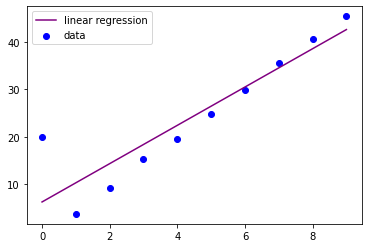

Point: [1. 0.], Value: 20.0, FIL: 0.905
Point: [1. 1.], Value: 3.7122597627259393, FIL: 1.405
Point: [1. 2.], Value: 9.261716708380066, FIL: 1.078
Point: [1. 3.], Value: 15.393180261983135, FIL: 0.685
Point: [1. 4.], Value: 19.611488036460766, FIL: 0.521
Point: [1. 5.], Value: 24.81139744122843, FIL: 0.258
Point: [1. 6.], Value: 29.935963626427213, FIL: 0.163
Point: [1. 7.], Value: 35.4526540598094, FIL: 0.417
Point: [1. 8.], Value: 40.59608776151395, FIL: 0.687
Point: [1. 9.], Value: 45.41101511022985, FIL: 0.925


In [ ]:
# define dataset
X_linear = np.arange(10)
y_linear = X_linear * 5 + np.random.normal(size=len(X_linear))
y_linear[0] = 20 # extraneous outlier

# define linear regression model
clf = LinearRegression().fit(X_linear.reshape(-1, 1), y_linear)

# calculate coefficients
learned_w = [clf.intercept_, clf.coef_[0]]
print("coefficients: {}, {}".format(learned_w[0], learned_w[1]))

# plot data with regression line
plt.scatter(X_linear, y_linear, label="data", color="blue")
plt.plot(X_linear, clf.predict(X_linear.reshape(-1, 1)), label="linear regression", color="purple")
plt.legend()
plt.show()

# run fisher information model
fil_linear = FIL_Linear(learned_w, add_bias(X_linear), y_linear)
fil_linear.compute_all_fils()
fil_linear.print_fil()

# for i in range(10):
#     print('jacobian:', i, fil_linear.jacobian(X_linear[i].reshape(-1,1), y_linear[i]))

In [ ]:
X_linear

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# define mnist dataset, working with digits 0 and 1
from tensorflow.keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
X_MNIST_train, y_MNIST_train, X_MNIST_test, y_MNIST_test = obtain_train_test_mnist(train_X[:1000], train_y[:1000], test_X[:200], test_y[:200], 4, 9)

clf = LogisticRegression(max_iter=1000).fit(X_MNIST_train, y_MNIST_train)

print("Logistic Regression Performance: {}".format(clf.score(X_MNIST_test, y_MNIST_test)))

learned_w = np.insert(clf.coef_, 0, clf.intercept_)

11493376/11490434 [==============================] - 0s 0us/step
Logistic Regression Performance: 0.9387755102040817


In [ ]:
fil_logistic_mnist = FIL_Logistic(learned_w, add_bias(X_MNIST_train), y_MNIST_train, lam=20)

print(fil_logistic_mnist.hessian_dataset().shape)

fil_logistic_mnist.fil(add_bias(X_MNIST_train)[0], y_MNIST_train[0])
# X_largest, fil_largest = fil_logistic_mnist.highest_fils(10)
# X_largest = remove_bias(X_largest).reshape(-1, 28, 28)

# for i in range(len(X_largest)):
#     plt.imshow(X_largest[i])
#     plt.colorbar()
#     plt.show()


(785, 785)


LinAlgError: Singular matrix

## FIL and OOD dataset

No handles with labels found to put in legend.


(-2.0, 2.0)

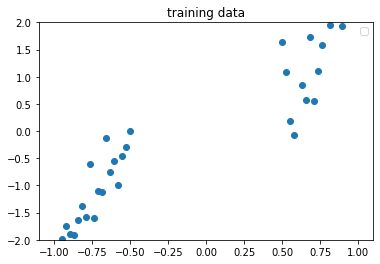

In [ ]:
def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    
    return x_train, y_train, x_test

N = 20
noise_variance = 0.3
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
plt.scatter(x_train, y_train)#, label = "training data")
#plt.plot(x_test, y_test, 'orange', label = "MLE fitted polynomial regression")
plt.title("training data")
plt.legend()
plt.ylim(-2, 2)

fisher info loss: tensor([0.0309, 0.0283, 0.0174, 0.0155, 0.0165, 0.0166, 0.0144, 0.0131, 0.0139,
        0.0147, 0.0139, 0.0112, 0.0109, 0.0173, 0.0104, 0.0112, 0.0093, 0.0106,
        0.0115, 0.0143, 0.0161, 0.0094, 0.0134, 0.0176, 0.0221, 0.0101, 0.0123,
        0.0153, 0.0139, 0.0116, 0.0138, 0.0226, 0.0171, 0.0199, 0.0201, 0.0168,
        0.0188, 0.0222, 0.0271, 0.0252])


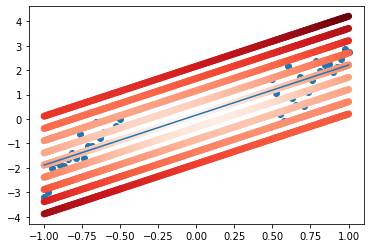

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(1)
# Make an instance of the LinearRegression to perform regression
linear_model = LinearRegression(fit_intercept=False)
# Fit a polynomial model
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
linear_model.fit(x_train_poly, y_train)
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
y_test = linear_model.predict(x_test_poly)

data = {"features": torch.from_numpy(x_train.reshape(-1, 1)).float(), "targets": torch.from_numpy(y_train).float()}
model = FIL_Linear_lxy()
model.train(data)

# print("coefficients:{}".format(model.get_params()))

#J = model.jacobian_dataset(data)
print('fisher info loss:', model.compute_all_fils())

dis_lst = [0, 0.5, 1, 1.5, 2]
plt.scatter(x_train, y_train)#, label = "training data")
plt.plot(x_test, y_test)
y_total = []
fil = []
for dis in dis_lst:
    y_new_low = y_test - dis
    y_new_upp = y_test + dis
    y_total = np.hstack((y_total, y_new_low))
    y_total = np.hstack((y_total, y_new_upp))
    fil_low = model.fil(torch.from_numpy(x_test.reshape(-1, 1)).float(),torch.tensor(y_new_low).float())
    fil_upp = model.fil(torch.from_numpy(x_test.reshape(-1, 1)).float(),torch.tensor(y_new_upp).float())
    fil += fil_low
    fil += fil_upp
plt.scatter([x_test]*2*len(dis_lst), y_total, c = fil, cmap = 'Reds')
#plt.scatter(x_test, y_new_upp, c = fil_low, cmap = 'Reds')
plt.show()


fisher info loss: tensor([0.0274, 0.0260, 0.0350, 0.0260, 0.0215, 0.0169, 0.0171, 0.0266, 0.0128,
        0.0190, 0.0142, 0.0117, 0.0142, 0.0143, 0.0151, 0.0157, 0.0131, 0.0088,
        0.0088, 0.0123, 0.0116, 0.0095, 0.0087, 0.0236, 0.0159, 0.0137, 0.0104,
        0.0156, 0.0119, 0.0117, 0.0127, 0.0125, 0.0181, 0.0266, 0.0211, 0.0224,
        0.0171, 0.0157, 0.0229, 0.0244])


fisher info loss: tensor([0.0361, 0.0339, 0.0248, 0.0232, 0.0241, 0.0242, 0.0224, 0.0212, 0.0221,
        0.0212, 0.0222, 0.0198, 0.0197, 0.0225, 0.0190, 0.0191, 0.0189, 0.0187,
        0.0190, 0.0204, 0.0210, 0.0176, 0.0215, 0.0247, 0.0255, 0.0186, 0.0204,
        0.0205, 0.0216, 0.0192, 0.0198, 0.0258, 0.0217, 0.0236, 0.0238, 0.0217,
        0.0229, 0.0254, 0.0295, 0.0279])
fisher info loss: tensor([0.0619, 0.0570, 0.0342, 0.0288, 0.0323, 0.0326, 0.0264, 0.0211, 0.0260,
        0.0209, 0.0274, 0.0193, 0.0195, 0.0220, 0.0185, 0.0187, 0.0199, 0.0186,
        0.0191, 0.0209, 0.0302, 0.0193, 0.0215, 0.0248, 0.0399, 0.0182, 0.0200,
        0.0273, 0.0212, 0.0188, 0.0220, 0.0410, 0.0299, 0.0358, 0.0363, 0.0290,
        0.0336, 0.0409, 0.0504, 0.0473])
fisher info loss: tensor([0.0542, 0.0499, 0.0298, 0.0265, 0.0275, 0.0279, 0.0231, 0.0216, 0.0234,
        0.0220, 0.0259, 0.0200, 0.0202, 0.0222, 0.0192, 0.0192, 0.0210, 0.0191,
        0.0194, 0.0208, 0.0314, 0.0206, 0.0215, 0.0246, 0.0402, 

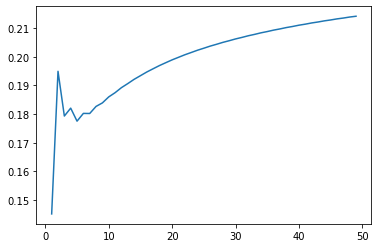

In [ ]:
from numpy import linalg as LA
D = range(1, 50)
res = []
for d in D:
    d = int(d)
    poly = PolynomialFeatures(d)
    # Make an instance of the LinearRegression to perform regression
    linear_model = LinearRegression(fit_intercept=False)
    # Fit a polynomial model
    x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
    linear_model.fit(x_train_poly, y_train)
    #x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    #y_test = linear_model.predict(x_test_poly)

    data = {"features": torch.from_numpy(x_train_poly.reshape(-1, d+1)).float(), "targets": torch.from_numpy(y_train).float()}
    model = FIL_Linear_lxy()
    model.train(data)
    fil = model.compute_all_fils()
    print('fisher info loss:', fil) 
    #plt.scatter(x_train, y_train, c = fil, cmap = 'Greens')
    res.append(LA.norm(np.array(fil)))

plt.plot(D, res)
# print("coefficients:{}".format(model.get_params()))

#J = model.jacobian_dataset(data)


# Conclusions：
（Todo）

In [ ]:
D

array([ 1.        ,  1.3877551 ,  1.7755102 ,  2.16326531,  2.55102041,
        2.93877551,  3.32653061,  3.71428571,  4.10204082,  4.48979592,
        4.87755102,  5.26530612,  5.65306122,  6.04081633,  6.42857143,
        6.81632653,  7.20408163,  7.59183673,  7.97959184,  8.36734694,
        8.75510204,  9.14285714,  9.53061224,  9.91836735, 10.30612245,
       10.69387755, 11.08163265, 11.46938776, 11.85714286, 12.24489796,
       12.63265306, 13.02040816, 13.40816327, 13.79591837, 14.18367347,
       14.57142857, 14.95918367, 15.34693878, 15.73469388, 16.12244898,
       16.51020408, 16.89795918, 17.28571429, 17.67346939, 18.06122449,
       18.44897959, 18.83673469, 19.2244898 , 19.6122449 , 20.        ])

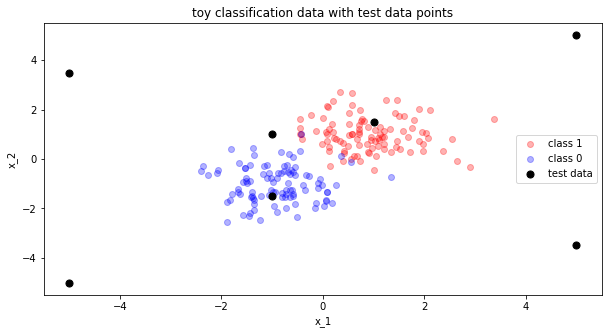

In [ ]:
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()


fisher info loss: tensor([0.0050, 0.0042, 0.0060, 0.0033, 0.0033, 0.0026, 0.0027, 0.0032, 0.0046,
        0.0017, 0.0049, 0.0030, 0.0031, 0.0026, 0.0042, 0.0044, 0.0031, 0.0039,
        0.0053, 0.0013, 0.0034, 0.0031, 0.0015, 0.0018, 0.0026, 0.0041, 0.0049,
        0.0024, 0.0045, 0.0027, 0.0034, 0.0044, 0.0053, 0.0012, 0.0056, 0.0044,
        0.0020, 0.0032, 0.0022, 0.0044, 0.0036, 0.0036, 0.0031, 0.0029, 0.0022,
        0.0036, 0.0030, 0.0053, 0.0008, 0.0038, 0.0049, 0.0020, 0.0015, 0.0028,
        0.0033, 0.0028, 0.0028, 0.0047, 0.0033, 0.0016, 0.0028, 0.0039, 0.0039,
        0.0035, 0.0031, 0.0022, 0.0042, 0.0015, 0.0050, 0.0018, 0.0059, 0.0018,
        0.0029, 0.0037, 0.0017, 0.0036, 0.0013, 0.0036, 0.0049, 0.0034, 0.0039,
        0.0050, 0.0045, 0.0042, 0.0024, 0.0022, 0.0017, 0.0023, 0.0035, 0.0013,
        0.0032, 0.0036, 0.0026, 0.0025, 0.0027, 0.0019, 0.0027, 0.0014, 0.0020,
        0.0034, 0.0027, 0.0085, 0.0041, 0.0033, 0.0046, 0.0037, 0.0030, 0.0057,
        0.0044, 0.0074

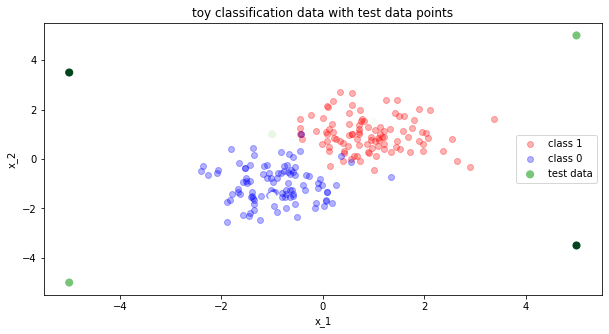

In [ ]:
data = {"features": torch.from_numpy(x.reshape(-1, 2)).float(), "targets": torch.from_numpy(y).float()}
model = FIL_Linear_lxy()
model.train(data)
print('fisher info loss:', model.compute_all_fils())

#x_test = []
#y_test = []
#for x_, y_ in test_points:
   # x_test.append([x_])
   # y_test.append(y_)
#x_test = np.array(x_test)
#y_test = np.array(y_test)
y_test = [0]*len(test_points)
fil = model.fil(torch.tensor(test_points).float(),torch.tensor(y_test).float())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
ax.scatter([x[0] for x in test_points], [x[1] for x in test_points], alpha=1., s=50, c=fil, cmap = 'Greens', label='test data')
#    else:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color=fil[i])
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()


In [ ]:
fil

tensor([0.0115, 0.0202, 0.0115, 0.0202, 0.0047, 0.0031, 0.0031])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3414c8e1-e8f2-444e-be94-05f51d01b06b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>